# A comparison of CoMIGHT against KSG and Linear Regression Based Estimates of Conditional Independence

CoMIGHT is a fully non-parametric method for i) estimating CMI and ii) providing a pvalue indicating the statistical significance of the estimated CMI compared to the null hypothesis where the CMI is 0 (for a given dimensionality and sample size using permutation principles).

Another nonparametric method for CMI is the kNN based KSG estimator, which also can be used along a permutation test to obtain a pvalue.

Finally, a parametric method for CMI is the linear regression method, which computes partial correlation among variables under the assumption that the data arises from Gaussian distributions.

In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
import math
from collections import defaultdict
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hyppo.conditional import ConditionalDcorr
from joblib import Parallel, delayed
from scipy.special import expit
from sklearn.datasets import (
    make_blobs,
    make_classification,
    make_sparse_spd_matrix,
    make_spd_matrix,
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sktree import HonestForestClassifier, RandomForestClassifier, RandomForestRegressor
from sktree.datasets.multiview import make_gaussian_mixture, make_joint_factor_model
from sktree.stats import (
    FeatureImportanceForestClassifier,
    FeatureImportanceForestRegressor,
    PermutationForestRegressor,
    PermutationTest,
)
from sktree.stats.utils import (
    METRIC_FUNCTIONS,
    POSITIVE_METRICS,
    POSTERIOR_FUNCTIONS,
    REGRESSOR_METRICS,
    _compute_null_distribution_coleman,
    _non_nan_samples,
)
from sktree.tree import DecisionTreeClassifier, MultiViewDecisionTreeClassifier

seed = 12345
rng = np.random.default_rng(seed)

In [38]:
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
from numpy import log
from scipy.special import digamma
from sklearn.neighbors import BallTree, KDTree


def add_noise(x, intens=1e-10):
    # small noise to break degeneracy, see doc.
    return x + intens * np.random.random_sample(x.shape)


def query_neighbors(tree, x, k):
    return tree.query(x, k=k + 1)[0][:, k]


def count_neighbors(tree, x, r):
    return tree.query_radius(x, r, count_only=True)


def avgdigamma(points, dvec):
    # This part finds number of neighbors in some radius in the marginal space
    # returns expectation value of <psi(nx)>
    tree = build_tree(points)
    dvec = dvec - 1e-15
    num_points = count_neighbors(tree, points, dvec)
    return np.mean(digamma(num_points))


def build_tree(points):
    if points.shape[1] >= 20:
        return BallTree(points, metric="chebyshev")
    return KDTree(points, metric="chebyshev")

In [5]:
def mi_ksg(x, y, z=None, k=3, base=2):
    """Mutual information of x and y (conditioned on z if z is not None)
    x, y should be a list of vectors, e.g. x = [[1.3], [3.7], [5.1], [2.4]]
    if x is a one-dimensional scalar and we have four samples
    """
    assert len(x) == len(y), "Arrays should have same length"
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    x, y = np.asarray(x), np.asarray(y)
    x, y = x.reshape(x.shape[0], -1), y.reshape(y.shape[0], -1)
    x = add_noise(x)
    y = add_noise(y)
    points = [x, y]
    if z is not None:
        z = np.asarray(z)
        z = z.reshape(z.shape[0], -1)
        points.append(z)
    points = np.hstack(points)
    # Find nearest neighbors in joint space, p=inf means max-norm
    tree = build_tree(points)
    dvec = query_neighbors(tree, points, k)
    if z is None:
        a, b, c, d = (
            avgdigamma(x, dvec),
            avgdigamma(y, dvec),
            digamma(k),
            digamma(len(x)),
        )
    else:
        xz = np.c_[x, z]
        yz = np.c_[y, z]
        a, b, c, d = (
            avgdigamma(xz, dvec),
            avgdigamma(yz, dvec),
            avgdigamma(z, dvec),
            digamma(k),
        )
    return (-a - b + c + d) / log(base)

# Define Dataset Generators

1. Confounder: Y <- X1 -> X2
2. Collider: X1 -> Y <- X2
3. Independence: X1 -> Y  X2 (here we use `make_classification` from sklearn and add random noise)
4. Mediator: X1 -> X2 -> Y
5. Direct & Indirect Effects: X1 -> X2 -> Y; X1 -> Y

In [141]:
def make_confounder(n_samples, n_features, n_features_2, noise_dims, class_probs, seed):
    rng = np.random.default_rng(seed)

    fixed_center = rng.standard_normal(size=(n_features_2,))
    centers = [fixed_center]

    if n_features_2 < n_features:
        raise RuntimeError("N features should be less than n features 2")

    signal_X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features + noise_dims,
        n_informative=n_features // 2,
        n_redundant=n_features // 2,
        n_repeated=0,
        n_classes=2,
        class_sep=1.0,
        flip_y=0.02,
        shuffle=False,
        random_state=seed,
    )

    # cov = make_spd_matrix(n_dim=n_features_2, random_state=seed + 123)
    signal_X_2 = signal_X[:, :n_features_2] * np.array(
        [0.72 / (i + 1) for i in range(n_features_2)]
    ) + rng.standard_normal(size=(n_samples, n_features_2))

    # print([x.shape for x in Xs])
    # signal_X = np.hstack((Xs[1], Xs[0]))
    signal_X = np.hstack((signal_X, signal_X_2))
    return signal_X, y

In [5]:
def make_directindirect(
    n_samples, n_features, n_features_2, noise_dims, class_probs, seed
):
    rng = np.random.default_rng(seed)

    fixed_center = rng.standard_normal(size=(n_features_2,))
    centers = [fixed_center, fixed_center]

    covariances = [
        make_spd_matrix(n_dim=n_features_2, random_state=seed),
        make_spd_matrix(n_dim=n_features_2, random_state=seed + 123),
    ]

    Xs, y = make_gaussian_mixture(
        centers,
        covariances,
        n_samples=n_samples,
        noise=1.0,
        noise_dims=0,
        shuffle=True,
        class_probs=class_probs,
        random_state=seed,
    )
    Xs[0] = Xs[0][:, :n_features]
    # print([x.shape for x in Xs])
    # print(Xs[0].shape)
    noise_arr = rng.standard_normal(size=(n_samples, noise_dims))
    # print(noise_arr.shape)
    # Xs[0] = np.hstack((Xs[0], ))
    signal_X = np.hstack((Xs[0], noise_arr, Xs[1]))

    return signal_X, y

In [111]:
def make_collider(n_samples, n_features, n_features_2, noise_dims, seed):
    rng = np.random.default_rng(seed)
    n_samples_ = n_samples * 2
    signal_X_1, y1 = make_classification(
        n_samples=n_samples_,
        n_features=n_features + noise_dims,
        n_informative=n_features // 2,
        n_redundant=n_features // 2,
        n_repeated=0,
        n_classes=2,
        class_sep=1.0,
        flip_y=0.04,
        shuffle=False,
        random_state=seed,
    )
    signal_X_2, y2 = make_classification(
        n_samples=n_samples_,
        n_features=n_features_2,
        n_informative=n_features_2,
        n_redundant=0,
        n_repeated=0,
        n_classes=2,
        class_sep=1.25,
        flip_y=0.03,
        shuffle=False,
        random_state=seed * 2,
    )
    # signal_X_2[:, : n_features_2 // 3] = np.exp(signal_X_2[:, : n_features_2 // 3])
    # signal_X_2[:, : n_features_2 // 3] = np.power(signal_X_2[:, 2 * n_features_2 // 3 :])
    signal_X_2[:, :n_features_2] = np.log(
        np.power(signal_X_2[:, 2 * n_features_2 // 3 :], 2)
    )
    # signal_X_1 = signal_X_1 + rng.standard_normal(size=signal_X_1.shape)
    # signal_X_2 = signal_X_2 + rng.standard_normal(size=signal_X_2.shape) / 2.0
    signal_X = np.hstack((signal_X_1, signal_X_2))
    y = y1.copy()

    keep_inds = np.argwhere(y1 == y2)
    y = y[keep_inds, ...]
    y2 = y2[keep_inds, ...].squeeze()
    signal_X = signal_X[keep_inds, ...].squeeze()

    np.testing.assert_array_equal(y.squeeze(), y2)

    # Separate indices of 0s and 1s
    indices_0 = [i for i, val in enumerate(y) if val == 0]
    indices_1 = [i for i, val in enumerate(y) if val == 1]

    # Shuffle the indices
    rng.shuffle(indices_0)
    rng.shuffle(indices_1)

    # Select 250 random indices for 0s and 1s each
    selected_indices = indices_0[: n_samples // 2] + indices_1[: n_samples // 2]
    signal_X = signal_X[selected_indices, :].squeeze()
    y2 = y2[selected_indices, ...].squeeze()
    return signal_X, y2

In [73]:
def make_log_collider(
    n_samples, n_features, n_features_2, noise_dims, noise_dims_2, seed
):
    """
    This generates a X1 -> y <- X2 where X2's log is correlated with y.

    X1 ~ N(0, 1) for n_features. Then X1 is concatenated with noise dimensions N(0, 1).

    X2
    """
    # generate X1
    x_1 = np.random.standard_normal(size=(n_samples, n_features)) * 5.0
    noise = np.random.standard_normal(size=(n_samples, noise_dims))
    x_1 = np.hstack((x_1, noise))

    # generate X2
    coeffs = np.array(
        [np.exp(-0.072 * (i + 10)) if i < 10 else 0 for i in range(n_features_2)]
    )
    coeffs_noise = np.array([1 if i >= 10 else 0 for i in range(n_features_2)])
    x2_noise = np.random.standard_normal(size=(n_samples, n_features_2)) / 5.0
    x_2_precursor = np.random.standard_normal(size=(n_samples, n_features_2))
    x_2 = np.log((x_2_precursor * coeffs + 1) ** 2) + x2_noise * coeffs_noise
    noise = np.random.standard_normal(size=(n_samples, noise_dims_2))
    x_2 = np.hstack((x_2, noise))

    x = np.hstack((x_1, x_2))

    # now generate y
    y = np.array([0] * (n_samples // 2) + [1] * (n_samples // 2)).reshape(-1, 1).ravel()
    return x, y

# Generate Datasets

In [60]:
# number of features in the first view
n_features = 10
noise_dims = 90
n_features_2 = 16
noise_dims_2 = 4096 - n_features_2 - (n_features + noise_dims)

n_samples_full = 2048
n_samples = 256
max_features = 0.3
n_jobs = -1
test_size = 0.2

class_probs = [0.5, 0.5]

max_fpr = 0.1

# number of features in the second view
pows = np.arange(2, 13, dtype=int)
n_features_2_list = [2**pow for pow in pows]
print(n_features_2_list)

[4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]


In [27]:
n_repeats = 100

In [28]:
print(n_features, noise_dims, n_features_2, noise_dims_2)

10 90 16 3980


## Log (Collider)

In [114]:
def generate_log_collider_dataset(
    n_samples,
    n_features,
    n_features_2,
    noise_dims,
    noise_dims_2,
    test_size,
    max_fpr,
    n_repeats,
):
    for idx in range(n_repeats):
        rng = np.random.default_rng(seed * idx)
        X, y = make_log_collider(
            n_samples, n_features, n_features_2, noise_dims, noise_dims_2, seed * idx
        )

        n_features_ends = [n_features + noise_dims, X.shape[1]]
        # print(X.shape, n_features_ends)
        np.savez(
            f"/Users/adam2392/Desktop/cancer/data/log_collider/log_collider_{idx}.npz",
            X=X,
            y=y,
        )

In [115]:
print(n_samples_full)

2048


In [ ]:
generate_log_collider_dataset(
    n_samples_full,
    n_features,
    n_features_2,
    noise_dims,
    noise_dims_2,
    test_size,
    max_fpr,
    100,
)

## Confounder

In [142]:
def generate_confounder_dataset(
    n_samples, n_features, n_features_2, class_probs, test_size, max_fpr, n_repeats
):
    for idx in range(n_repeats):
        rng = np.random.default_rng(seed * idx)
        signal_X, y = make_confounder(
            n_samples=n_samples,
            n_features=n_features,
            n_features_2=n_features_2,
            noise_dims=100 - n_features,
            class_probs=class_probs,
            seed=seed * idx,
        )
        X = np.hstack(
            (
                signal_X,
                rng.standard_normal(
                    size=(
                        n_samples,
                        n_features_2_list[-1]
                        - signal_X.shape[1]
                        + n_features
                        + noise_dims,
                    )
                ),
            )
        )
        # signal_X = np.hstack(
        #     (
        #         signal_X,
        #         rng.standard_normal(
        #             size=(n_samples, (noise_dims + n_features - n_features_2))
        #         ),
        #     )
        # )
        # # signal_X = np.hstack((signal_X, Xs[1][:, :4]))
        # n_features_ends_one = 100
        # # signal_X = np.hstack((signal_X, Xs[1]))
        # # second_view_dim = Xs[1].shape[1]

        n_features_ends = [n_features + noise_dims, X.shape[1]]
        # _X = signal_X.copy()
        # second_view_dim = n_features_2 - n_features_ends[0]
        # # if n_features_2_ - second_view_dim > 0:
        # _X = np.hstack(
        #     (
        #         _X,
        #         rng.standard_normal(
        #             size=(n_samples, n_features_2_list[-1] - second_view_dim)
        #         ),
        #     )
        # )
        # X = _X.copy()
        n_features_ends[1] = X.shape[1]
        # print(signal_X.shape, X.shape, n_features_ends)
        np.savez(f"./confounder/confounder_{idx}.npz", X=X, y=y)

In [143]:
generate_confounder_dataset(
    n_samples_full, n_features, n_features_2, class_probs, test_size, max_fpr, n_repeats
)

## Collider

In [129]:
def generate_collider_dataset(
    n_samples,
    n_features,
    # n_features_2,
    class_probs,
    test_size,
    max_fpr,
    n_repeats,
    seed,
):
    rng = np.random.default_rng(seed)
    for idx in range(n_repeats):
        signal_X, y = make_collider(
            n_samples=n_samples,
            n_features=n_features,
            n_features_2=n_features_2,
            noise_dims=noise_dims,
            seed=seed * idx,
        )
        n_features_ends = [n_features + noise_dims, None]

        # print(signal_X.shape, y.shape)
        _X = np.hstack(
            (
                signal_X,
                rng.standard_normal(
                    size=(
                        n_samples,
                        n_features_2_list[-1] - (n_features_2),
                    )
                ),
            )
        )

        X = _X.copy()
        n_features_ends[1] = X.shape[1]
        # print(X.shape, signal_X.shape, n_features_ends, y.shape)
        np.savez(f"./collider/collider_{idx}.npz", X=X, y=y)

In [130]:
generate_collider_dataset(
    n_samples_full, n_features, class_probs, test_size, max_fpr, n_repeats, seed
)

## Direct/Indirect Effects

In [380]:
def generate_directindirect_dataset(
    n_samples,
    n_features,
    n_features_2,
    class_probs,
    test_size,
    max_fpr,
    n_repeats,
    seed,
):
    for idx in range(n_repeats):
        rng = np.random.default_rng(seed * idx)
        signal_X, y = make_directindirect(
            n_samples=n_samples,
            n_features=n_features,
            n_features_2=n_features_2,
            noise_dims=100 - n_features,
            class_probs=class_probs,
            seed=seed * idx,
        )
        X = np.hstack(
            (
                signal_X,
                rng.standard_normal(
                    size=(n_samples, n_features_2_list[-1] - n_features_2)
                ),
            )
        )
        # # signal_X = np.hstack((signal_X, Xs[1][:, :4]))
        # n_features_ends_one = 100
        # signal_X = np.hstack((signal_X, Xs[1]))
        # second_view_dim = Xs[1].shape[1]

        n_features_ends = [n_features + noise_dims, None]
        # _X = signal_X.copy()
        # second_view_dim = n_features_2 - n_features_ends[0]
        # # # if n_features_2_ - second_view_dim > 0:
        # _X = np.hstack(
        #     (
        #         _X,
        #         rng.standard_normal(
        #             size=(n_samples, n_features_2_list[-1] - second_view_dim)
        #         ),
        #     )
        # )
        # X = _X.copy()
        n_features_ends[1] = X.shape[1]
        print(signal_X.shape, X.shape, n_features_ends)
        np.savez(f"./direct-indirect/direct-indirect_{idx}.npz", X=X, y=y)

In [381]:
generate_directindirect_dataset(
    n_samples_full,
    n_features,
    n_features_2,
    class_probs,
    test_size,
    max_fpr,
    n_repeats,
    seed,
)

(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(2048, 132) (2048, 4196) [100, 4196]
(

## Independent View

In [382]:
def generate_independent_dataset(
    n_samples, n_features, class_probs, test_size, max_fpr, n_repeats, seed
):
    rng = np.random.default_rng(seed)
    for idx in range(n_repeats):
        n_features_begin = 0
        signal_X, y = make_classification(
            n_samples=n_samples,
            n_features=n_features + noise_dims,
            n_redundant=0,
            shuffle=True,
            n_informative=n_features,
            random_state=seed * idx,
        )
        n_features_ends = [n_features + noise_dims, None]

        _X = np.hstack(
            (signal_X, rng.standard_normal(size=(n_samples, n_features_2_list[-1])))
        )
        X = _X.copy()
        n_features_ends[1] = X.shape[1]

        # print(X.shape, signal_X.shape, n_features_ends)
        np.savez(f"./independent/independent_{idx}.npz", X=X, y=y)

In [383]:
generate_independent_dataset(
    n_samples_full, n_features, class_probs, test_size, max_fpr, n_repeats, seed
)

In [46]:
def sensitivity_at_spec_threshold(est, X, y, train_idx, test_idx, threshold):
    X_train = X[train_idx, :]
    train_posteriors = est.predict_proba(X_train)

    y_train = y[train_idx]
    num_cancers = y_train[y_train == 1]
    num_normals = y_train[y_train == 0]

    # at specificity threshold, compute the necessary posterior value
    normal_posteriors = np.sort(train_posteriors[y_train == 0])
    posterior_threshold = normal_posteriors[int(num_normals * threshold)]

    num_cancers_specificity = len(np.where(cancer_data > posterior)[0])
    sensitivity = num_cancers_specificity / num_cancers
    return sensitivity

# Parallelizable function for any simulation

In [46]:
def _run_parallel_sim(
    idx,
    n_samples,
    n_features,
    class_probs,
    seed,
    n_features_2,
    test_size,
    max_fpr,
    sim_type,
    only_compute_stat=True,
):
    n_jobs = 1
    results = defaultdict(list)
    rng = np.random.default_rng(seed)
    n_features_ends = [100, None]

    if sim_type == "confounder":
        npy_data = np.load(f"./confounder/confounder_{idx}.npz")
    elif sim_type == "collider":
        npy_data = np.load(f"./collider/collider_{idx}.npz")
    elif sim_type == "mediator":
        npy_data = np.load(f"./mediator/mediator_{idx}.npz")
    elif sim_type == "direct-indirect":
        npy_data = np.load(f"./direct-indirect/direct-indirect_{idx}.npz")
    elif sim_type == "independent":
        npy_data = np.load(f"./independent/independent_{idx}.npz")
    elif sim_type == "log_collider":
        npy_data = np.load(
            f"/Users/adam2392/Desktop/cancer/data/log_collider/log_collider_{idx}.npz"
        )

    X = npy_data["X"]
    y = npy_data["y"]
    # print(X.shape, y.shape)

    X = X[:, : 100 + n_features_2]
    if n_samples < X.shape[0]:
        cv = StratifiedShuffleSplit(n_splits=1, train_size=n_samples)
        for train_idx, _ in cv.split(X, y):
            continue
        X = X[train_idx, :]
        y = y[train_idx, ...].squeeze()
    assert len(X) == len(y)
    assert len(y) == n_samples
    n_features_ends[1] = X.shape[1]

    est = FeatureImportanceForestClassifier(
        estimator=HonestForestClassifier(
            n_estimators=n_estimators,
            tree_estimator=MultiViewDecisionTreeClassifier(
                max_features=[max_features, min(n_features_2, max_features * 100)],
                feature_set_ends=n_features_ends,
                apply_max_features_per_feature_set=True,
            ),
            random_state=seed,
            honest_fraction=0.5,
            n_jobs=n_jobs,
        ),
        random_state=seed,
        test_size=test_size,
        sample_dataset_per_tree=False,
    )
    svm = SVC(probability=True)
    neigh = KNeighborsClassifier()
    lr = LogisticRegression(random_state=seed, penalty="l1", solver="liblinear")

    posteriors_list = []
    posteriors_dict = dict()
    if only_compute_stat:
        # only compute statistics
        stat, posteriors, _ = est.statistic(
            X, y, metric="auc", return_posteriors=True, max_fpr=max_fpr
        )
        # print(posteriors.shape, X.shape, y.shape)
        results["mvrf_pauc"].append(stat)
        svm_stats = cross_val_score(svm, X, y, scoring=partial_auc_score, cv=2)
        # print("finished svm")
        neigh_stats = cross_val_score(neigh, X, y, scoring=partial_auc_score, cv=2)
        # print("finished knn")
        lr_stats = cross_val_score(lr, X, y, scoring=partial_auc_score, cv=2)
        # print("finished lr")
        # print(np.mean(svm_stats), np.mean(neigh_stats), np.mean(lr_stats))
        results["svm_pauc"].append(np.mean(svm_stats))
        results["knn_pauc"].append(np.mean(neigh_stats))
        results["lr_pauc"].append(np.mean(lr_stats))
    else:
        # compute the statistic
        # also compute the pvalue when shuffling X1
        covariate_index = np.arange(0, n_features_ends[0])
        stat, pvalue = est.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        results["mvrf_pvalue_x1"].append(pvalue)
        # get the actual partial-AUC of the unpermuted dataset for the forest
        stat = est.observe_stat_
        results["mvrf_pauc"].append(stat)

        # now compute the same relevant quantities using kNN
        # compute pvalue for kNN based job
        perm_test = PermutationTest(neigh, n_repeats=50, random_state=seed)
        pauc, pvalue = perm_test.test(
            X,
            y,
            covariate_index=covariate_index,
            return_posteriors=True,
            metric="auc",
            max_fpr=max_fpr,
        )
        knn_posteriors_x1 = perm_test.posteriors_
        knn_null_posteriors_x1 = perm_test.posteriors_null_
        posteriors_dict["knn_x1"] = knn_posteriors_x1
        posteriors_dict["knn_null_x1"] = knn_null_posteriors_x1
        results["knn_pauc"].append(pauc)
        results["knn_pvalue_x1"].append(pvalue)

        # compute same relevant quantities using SVM
        perm_test = PermutationTest(svm, n_repeats=50, random_state=seed)
        pauc, pvalue = perm_test.test(
            X,
            y,
            covariate_index=covariate_index,
            return_posteriors=True,
            metric="auc",
            max_fpr=max_fpr,
        )
        svm_posteriors_x1 = perm_test.posteriors_
        svm_null_posteriors_x1 = perm_test.posteriors_null_
        posteriors_dict["svm_x1"] = svm_posteriors_x1
        posteriors_dict["svm_null_x1"] = svm_null_posteriors_x1
        results["svm_pauc"].append(pauc)
        results["svm_pvalue_x1"].append(pvalue)

        # also compute the relevant quantities using linear regression
        perm_test = PermutationTest(lr, n_repeats=50, random_state=seed)
        pauc, pvalue = perm_test.test(
            X,
            y,
            covariate_index=covariate_index,
            return_posteriors=True,
            metric="auc",
            max_fpr=max_fpr,
        )
        lr_posteriors_x1 = perm_test.posteriors_
        lr_null_posteriors_x1 = perm_test.posteriors_null_
        posteriors_dict["lr_x1"] = lr_posteriors_x1
        posteriors_dict["lr_null_x1"] = lr_null_posteriors_x1
        results["lr_pvalue_x1"].append(pvalue)
        results["lr_pauc"].append(pauc)

        # now compute the pvalue when shuffling X2
        covariate_index = np.arange(n_features_ends[0], n_features_ends[1])
        _, pvalue = est.test(
            X,
            y,
            covariate_index=covariate_index,
            return_posteriors=True,
            metric="auc",
            max_fpr=max_fpr,
        )
        results["mvrf_pvalue_x2"].append(pvalue)

        # now compute the same relevant quantities using kNN
        # compute pvalue for kNN based job
        perm_test = PermutationTest(neigh, n_repeats=50, random_state=seed)
        _, pvalue = perm_test.test(
            X,
            y,
            covariate_index=covariate_index,
            return_posteriors=True,
            metric="auc",
            max_fpr=max_fpr,
        )
        knn_posteriors_x2 = perm_test.posteriors_
        knn_null_posteriors_x2 = perm_test.posteriors_null_
        posteriors_dict["knn_x2"] = knn_posteriors_x2
        posteriors_dict["knn_null_x2"] = knn_null_posteriors_x2
        results["knn_pvalue_x2"].append(pvalue)

        # compute same relevant quantities using SVM
        perm_test = PermutationTest(svm, n_repeats=50, random_state=seed)
        _, pvalue = perm_test.test(
            X,
            y,
            covariate_index=covariate_index,
            return_posteriors=True,
            metric="auc",
            max_fpr=max_fpr,
        )
        svm_posteriors_x2 = perm_test.posteriors_
        svm_null_posteriors_x2 = perm_test.posteriors_null_
        posteriors_dict["svm_x2"] = svm_posteriors_x2
        posteriors_dict["svm_null_x2"] = svm_null_posteriors_x2
        results["svm_pvalue_x2"].append(pvalue)

        # also compute the relevant quantities using linear regression
        perm_test = PermutationTest(lr, n_repeats=100, random_state=seed)
        _, pvalue = perm_test.test(
            X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
        )
        lr_posteriors_x2 = perm_test.posteriors_
        lr_null_posteriors_x2 = perm_test.posteriors_null_
        posteriors_dict["lr_x2"] = lr_posteriors_x2
        posteriors_dict["lr_null_x2"] = lr_null_posteriors_x2
        results["lr_pvalue_x2"].append(pvalue)

    results["n_samples"].append(n_samples)
    results["n_features_2"].append(n_features_2)
    results["noise_dims"].append(noise_dims)
    return results

In [118]:
def _run_parallel_posterior_sim(
    idx,
    n_samples,
    n_features,
    class_probs,
    seed,
    n_features_2,
    test_size,
    max_fpr,
    sim_type,
):
    n_jobs = 1
    results = defaultdict(list)
    rng = np.random.default_rng(seed)
    n_features_ends = [100, None]

    if sim_type == "confounder":
        npy_data = np.load(
            f"/Users/adam2392/Desktop/cancer/data/confounder/confounder_{idx}.npz"
        )
    elif sim_type == "collider":
        npy_data = np.load(f"./collider/collider_{idx}.npz")
    elif sim_type == "mediator":
        npy_data = np.load(
            f"/Users/adam2392/Desktop/cancer/data/mediator/mediator_{idx}.npz"
        )
    elif sim_type == "direct-indirect":
        npy_data = np.load(
            f"/Users/adam2392/Desktop/cancer/data/direct-indirect/direct-indirect_{idx}.npz"
        )
    elif sim_type == "independent":
        npy_data = np.load(
            f"/Users/adam2392/Desktop/cancer/data/independent/independent_{idx}.npz"
        )

    X = npy_data["X"]
    y = npy_data["y"]
    # print(X.shape, y.shape)

    X = X[:, : 100 + n_features_2]
    if n_samples < X.shape[0]:
        cv = StratifiedShuffleSplit(n_splits=1, train_size=n_samples)
        for train_idx, _ in cv.split(X, y):
            continue
        X = X[train_idx, :]
        y = y[train_idx, ...].squeeze()
    assert len(X) == len(y)
    assert len(y) == n_samples
    n_features_ends[1] = X.shape[1]

    est = FeatureImportanceForestClassifier(
        estimator=HonestForestClassifier(
            n_estimators=n_estimators,
            tree_estimator=MultiViewDecisionTreeClassifier(
                max_features=[max_features, min(n_features_2, max_features * 100)],
                feature_set_ends=n_features_ends,
                apply_max_features_per_feature_set=True,
            ),
            random_state=seed,
            honest_fraction=0.5,
            n_jobs=n_jobs,
        ),
        random_state=seed,
        test_size=test_size,
        sample_dataset_per_tree=False,
    )

    posteriors_dict = dict()

    # now compute the pvalue when shuffling X2
    covariate_index = np.arange(n_features_ends[0], n_features_ends[1])

    # estimate (conditional) mutual information using KSG
    # Z = X[:, covariate_index]
    # mask_array = np.ones(X.shape[1])
    # mask_array[covariate_index] = 0
    # mask_array = mask_array.astype(bool)
    # X_minus_Z = X[:, mask_array]
    # cmi_ksg = mi_ksg(X_minus_Z.copy(), y.copy(), Z.copy())
    # results["ksg_cmi"].append(cmi_ksg)

    # Estimate CMI with
    mi_rf, pvalue = est.test(
        X,
        y,
        covariate_index=covariate_index,
        return_posteriors=True,
        metric="mi",
        # max_fpr=max_fpr,
    )
    comight_posteriors_x2 = est.observe_posteriors_
    comight_null_posteriors_x2 = est.permute_posteriors_

    samples = est.observe_samples_
    permute_samples = est.permute_samples_

    assert np.isnan(comight_posteriors_x2[:, samples, :]).sum() == 0

    # results["mvrf_samples"].append(est.observe_samples_)
    # results["mvrf_null_samples"].append(est.permute_samples_)
    results["mvrf_mi"].append(mi_rf)
    results["mvrf_pvalue_x2"].append(pvalue)
    results["y_true"].append(y)
    results["n_samples"].append(n_samples)
    results["n_features_2"].append(n_features_2)
    results["noise_dims"].append(noise_dims)

    np.savez(
        f"./varying-dimensionality/{sim_type}/comight_posteriors_{n_samples}_{n_features_2}_{idx}.npz",
        posteriors=comight_posteriors_x2,
        null_posteriors=comight_null_posteriors_x2,
        samples=samples,
        permute_samples=permute_samples,
        n_samples=n_samples,
        n_features_2=n_features_2,
        y_true=y,
        # cmi_ksg=cmi_ksg,
    )

    # cdcorr = ConditionalDcorr(bandwidth="silverman")
    # Z = X[:, covariate_index]
    # mask_array = np.ones(X.shape[1])
    # mask_array[covariate_index] = 0
    # mask_array = mask_array.astype(bool)

    # X_minus_Z = X[:, mask_array]
    # print(Z, np.var(Z))
    # # print(X_minus_Z, np.var(X_minus_Z))
    # print(Z.shape, X_minus_Z.shape, X.shape, y.shape)
    # cdcorr_stat, cdcorr_pvalue = cdcorr.test(X_minus_Z.copy(), y.copy(), Z.copy())
    # results["cdcorr_pvalue_x2"].append(cdcorr_pvalue)
    # results["cdcorr_stat_x2"].append(cdcorr_stat)

    # results["mvrf_posteriors"].append(comight_posteriors_x2)
    # results["mvrf_null_posteriors"].append(comight_null_posteriors_x2)
    return results

In [52]:
def partial_auc_score(est, X, y):
    y_score = est.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_score, max_fpr=0.1)

# Run Computation Varying Dimensionality of X2

Warning: For high n_repeats, this takes a long time.

In [40]:
# NOTE: increase this when running for full figure to 100
n_repeats = 100

In [41]:
class_probs = [0.5, 0.5]

In [42]:
# number of features in the first view
n_features = 10
noise_dims = 90

n_samples = 256
max_features = 0.3
n_jobs = -1
test_size = 0.2

max_fpr = 0.1

# number of features in the second view
pows = np.arange(2, 13, dtype=int)
n_features_2_list = [0] + [2**pow for pow in pows]

n_features_2_list = [2**pow for pow in pows]
print(n_features_2_list)

[4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]


In [43]:
n_estimators = 500

## Independent Results

In [85]:
_results_ind_extra = Parallel(n_jobs=-1)(
    delayed(_run_parallel_sim)(
        idx_,
        n_samples,
        n_features,
        class_probs,
        seed,
        n_features_2_,
        test_size,
        max_fpr,
        "independent",
        True,
    )
    for (idx_, n_features_2_) in product(range(n_repeats), n_features_2_list)
)

In [ ]:
results = defaultdict(list)
for result in _results_ind:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_independent_model_fullv2.csv")

print(df.columns)
print(df.shape)

## Confounder Results

In [ ]:
_results_confounder = Parallel(n_jobs=-1)(
    delayed(_run_parallel_sim)(
        idx_,
        n_samples,
        n_features,
        class_probs,
        seed,
        n_features_2_,
        test_size,
        max_fpr,
        "confounder",
        True,
    )
    for (idx_, n_features_2_) in product(range(n_repeats), n_features_2_list)
)

/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/mini

In [ ]:
results = defaultdict(list)
for result in _results_confounder:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_confounder_model_fullv2.csv")

print(df.columns)
print(df.shape)

## Collider Results

In [278]:
_results_collider = Parallel(n_jobs=-1)(
    delayed(_run_parallel_sim)(
        idx_,
        n_samples,
        n_features,
        class_probs,
        seed,
        n_features_2_,
        test_size,
        max_fpr,
        "collider",
        True,
    )
    for (idx_, n_features_2_) in product(range(n_repeats), n_features_2_list)
)

/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/mini

In [279]:
results = defaultdict(list)
for result in _results_collider:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_collider_model_fullv2.csv")

print(df.columns)
print(df.shape)

Index(['mvrf_pauc', 'svm_pauc', 'knn_pauc', 'lr_pauc', 'n_samples',
       'n_features_2', 'noise_dims'],
      dtype='object')
(1200, 7)


## Direct-Indirect Results

In [368]:
print(n_features_2_list)

[4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]


In [369]:
_results_directindirect = Parallel(n_jobs=-1)(
    delayed(_run_parallel_sim)(
        idx_,
        n_samples,
        n_features,
        class_probs,
        seed,
        n_features_2_,
        test_size,
        max_fpr,
        "direct-indirect",
        True,
    )
    for (idx_, n_features_2_) in product(range(n_repeats), n_features_2_list)
)

In [370]:
results = defaultdict(list)
for result in _results_directindirect:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_directindirect_model_fullv2.csv")

print(df.columns)
print(df.shape)

Index(['mvrf_pauc', 'svm_pauc', 'knn_pauc', 'lr_pauc', 'n_samples',
       'n_features_2', 'noise_dims'],
      dtype='object')
(1100, 7)


## Log_Collider Results

In [ ]:
print(n_features_2_list)

In [ ]:
_results_directindirect = Parallel(n_jobs=-1)(
    delayed(_run_parallel_sim)(
        idx_,
        n_samples,
        n_features,
        class_probs,
        seed,
        n_features_2_,
        test_size,
        max_fpr,
        "log_collider",
        True,
    )
    for (idx_, n_features_2_) in product(range(n_repeats), n_features_2_list)
)

In [ ]:
results = defaultdict(list)
for result in _results_directindirect:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_logcollider_model_fullv2.csv")

print(df.columns)
print(df.shape)

# Run Computation Varying Sample-size

Here, X2 is fixed at 4096 dimensions.

In [397]:
n_features_2 = 4096
n_samples_list = [2**x for x in range(6, 12)]
print(n_samples_list)

[64, 128, 256, 512, 1024, 2048]


## Independent Results

In [398]:
_results_ind = Parallel(n_jobs=-1)(
    delayed(_run_parallel_sim)(
        idx_,
        n_samples_,
        n_features,
        class_probs,
        seed,
        n_features_2,
        test_size,
        max_fpr,
        "independent",
        True,
    )
    for (idx_, n_samples_) in product(range(n_repeats), n_samples_list)
)

In [400]:
results = defaultdict(list)
for result in _results_ind_extra:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_independent_model_varying_samples_full.csv")

print(df.columns)
print(df.shape)

Index(['mvrf_pauc', 'svm_pauc', 'knn_pauc', 'lr_pauc', 'n_samples',
       'n_features_2', 'noise_dims'],
      dtype='object')
(600, 7)


## Confounder Results

In [413]:
_results_confounder = Parallel(n_jobs=-1)(
    delayed(_run_parallel_sim)(
        idx_,
        n_samples_,
        n_features,
        class_probs,
        seed,
        n_features_2,
        test_size,
        max_fpr,
        "confounder",
        True,
    )
    for (idx_, n_samples_) in product(range(n_repeats), n_samples_list)
)

/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/mini

In [414]:
results = defaultdict(list)
for result in _results_confounder:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_confounder_model_varying_samples_full.csv")

print(df.columns)
print(df.shape)

Index(['mvrf_pauc', 'svm_pauc', 'knn_pauc', 'lr_pauc', 'n_samples',
       'n_features_2', 'noise_dims'],
      dtype='object')
(600, 7)


## Collider Results

In [415]:
_results_collider = Parallel(n_jobs=-1)(
    delayed(_run_parallel_sim)(
        idx_,
        n_samples_,
        n_features,
        class_probs,
        seed + 1,
        n_features_2,
        test_size,
        max_fpr,
        "collider",
        True,
    )
    for (idx_, n_samples_) in product(range(n_repeats), n_samples_list)
)

/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/mini

In [416]:
results = defaultdict(list)
for result in _results_collider:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_collider_model_varying_samples_full.csv")

print(df.columns)
print(df.shape)

Index(['mvrf_pauc', 'svm_pauc', 'knn_pauc', 'lr_pauc', 'n_samples',
       'n_features_2', 'noise_dims'],
      dtype='object')
(600, 7)


## Direct-Indirect Results

In [417]:
_results_directindirect = Parallel(n_jobs=-1)(
    delayed(_run_parallel_sim)(
        idx_,
        n_samples_,
        n_features,
        class_probs,
        seed,
        n_features_2,
        test_size,
        max_fpr,
        "direct-indirect",
        True,
    )
    for (idx_, n_samples_) in product(range(n_repeats), n_samples_list)
)

In [418]:
results = defaultdict(list)
for result in _results_directindirect:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_directindirect_model_varying_samples_full.csv")

print(df.columns)
print(df.shape)

Index(['mvrf_pauc', 'svm_pauc', 'knn_pauc', 'lr_pauc', 'n_samples',
       'n_features_2', 'noise_dims'],
      dtype='object')
(600, 7)


# Plotting the Results

In [83]:
print("done")

done


In [69]:
df = pd.DataFrame(results)

print(df.shape)
display(df.head())

(1100, 7)


,mvrf_pauc,svm_pauc,knn_pauc,lr_pauc,n_samples,n_features_2,noise_dims
0,0.490813,0.482550,0.494441,0.489618,256,4,90
1,0.570227,0.502596,0.495251,0.477668,256,8,90
2,0.548427,0.529580,0.482421,0.483835,256,16,90
3,0.506384,0.510819,0.493118,0.500540,256,32,90
4,0.514170,0.482679,0.491611,0.521998,256,64,90


In [429]:
df = pd.read_csv(
    "./cv_comight_mv_vs_knn_vs_lr_independent_model_full.csv", index_col=0, header=0
)
df = pd.read_csv(
    "./cv_comight_mv_vs_knn_vs_lr_collider_model_full.csv", index_col=0, header=0
)

# df = pd.read_csv(
#     "./cv_comight_mv_vs_knn_vs_lr_confounder_model_full.csv", index_col=0, header=0
# )

# df = pd.read_csv(
#     "./cv_comight_mv_vs_knn_vs_lr_mediator_model_full.csv", index_col=0, header=0
# )

# df = pd.read_csv(
#     "./cv_comight_mv_vs_knn_vs_lr_directindirect_model_full.csv", index_col=0, header=0
# )

df = pd.read_csv(
    "./cv_comight_mv_vs_knn_vs_lr_independent_model_varying_samples_full.csv",
    index_col=0,
    header=0,
)

df = pd.read_csv(
    "./cv_comight_mv_vs_knn_vs_lr_confounder_model_varying_samples_full.csv",
    index_col=0,
    header=0,
)

df = pd.read_csv(
    "./cv_comight_mv_vs_knn_vs_lr_collider_model_varying_samples_full.csv",
    index_col=0,
    header=0,
)

df = pd.read_csv(
    "./cv_comight_mv_vs_knn_vs_lr_directindirect_model_varying_samples_full.csv",
    index_col=0,
    header=0,
)

print(df.shape)
display(df.head())

(600, 7)


,mvrf_pauc,svm_pauc,knn_pauc,lr_pauc,n_samples,n_features_2,noise_dims
0,0.649123,0.505662,0.551196,0.505582,64,4096,90
1,0.604485,0.513557,0.545695,0.520084,128,4096,90
2,0.778885,0.498806,0.572256,0.521652,256,4096,90
3,0.807494,0.500989,0.573175,0.508043,512,4096,90
4,0.863286,0.504738,0.576367,0.495548,1024,4096,90


In [ ]:
# melt the dataframe, to make it easier to plot
df.drop(
    [
        "noise_dims",
        # "lr_pauc",
        # "knn_pauc",
        # "mvrf_pauc",
        # "mvrf_pvalue_x2",
        # "lr_pvalue_x2",
        # "knn_pvalue_x2",
        # "mvrf_pvalue_x1",
        # "lr_pvalue_x1",
        # "knn_pvalue_x1",
    ],
    inplace=True,
    axis=1,
)
df = pd.melt(
    df,
    id_vars=["n_features_2", "n_samples"],
    var_name="model",
    value_name="score",
)

# df["score"] = (df["score"] - 0.5) / 0.5

name_map = {
    "mvrf_pauc": "CoMIGHT",
    "knn_pauc": "kNN",
    "lr_pauc": "LR",
    "svm_pauc": "SVM",
}
# name_map = {
#     "mvrf_pvalue_x2": "CoMIGHT",
#     "knn_pvalue_x2": "kNN",
#     "lr_pvalue_x2": "LR",
# }
# name_map = {
#     "mvrf_pvalue_x1": "CoMIGHT",
#     "knn_pvalue_x1": "kNN",
#     "lr_pvalue_x1": "LR",
# }
df["model"] = df["model"].map(name_map)

# df["reject"] = df["score"] < 0.05

# display(df.head())

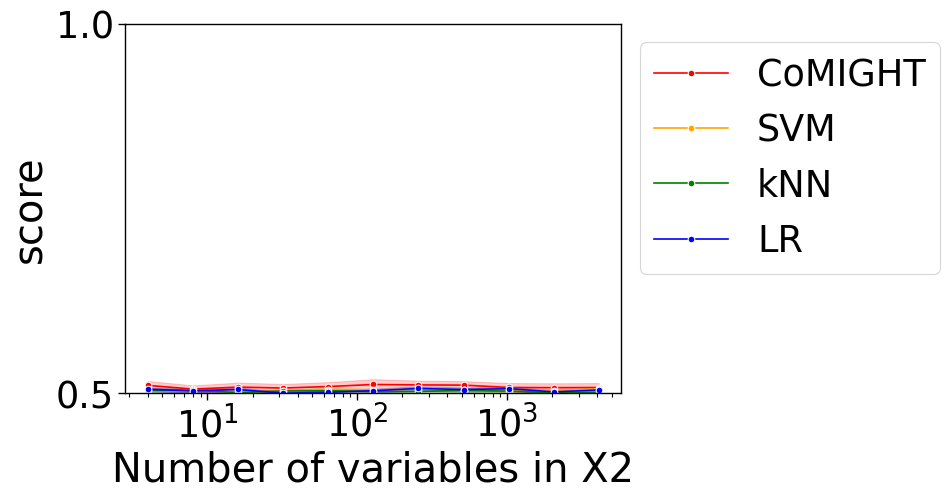

In [84]:
sns.set_context("paper", font_scale=3.0)
fig, ax = plt.subplots()

palette = {"CoMIGHT": "red", "SVM": "orange", "kNN": "green", "LR": "blue"}

ax = sns.lineplot(
    data=df,
    x="n_features_2",
    y="score",
    marker="o",
    hue="model",
    ax=ax,
    palette=palette,
    errorbar="ci",
)

# ax.set_ylabel("Partial-AUC \n(at 90% Specificity)")
ax.set_xlabel("Number of variables in X2")
# ax.set_xlabel("Sample size")
# ax.set_title("Collider\n")
# ax.axvline([32], ls="--", color="black", label="Noise Dimensions")
ax.set(
    ylim=[0.5, 1],
    yticks=[0.5, 1],
    # xticks=[0, 50, 100, 1000, 4000],
)
ax.set_xscale("log")
# xticks = ax.get_xticks()
# print(xticks)
# xticks = np.concatenate(([0], xticks))
# ax.set(xticks=xticks)
ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [71]:
df = pd.DataFrame(np.concatenate((X, y[:, np.newaxis]), axis=1))
x_cols = np.array([f"x{idx}" for idx in range(X.shape[1])])
y_cols = np.array([f"y0"])
z_cols = x_cols[0:2]
df.columns = np.hstack((x_cols, y_cols))
print(df.columns)

NameError: name 'X' is not defined

# PValue Computations Varying Dimensionality of X2

In [87]:
print(n_features_2_list)

[4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]


In [91]:
n_samples = 1024

## Independent Results

In [98]:
_results_ind = Parallel(n_jobs=-1)(
    delayed(_run_parallel_posterior_sim)(
        idx_,
        n_samples,
        n_features,
        class_probs,
        seed,
        n_features_2_,
        test_size,
        max_fpr,
        "independent",
    )
    for (idx_, n_features_2_) in product(range(n_repeats), n_features_2_list)
)

In [64]:
results = defaultdict(list)
for result in _results_ind:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_independent_model_varyingdims_pvalues.csv")

print(df.columns)
print(df.shape)

Index(['mvrf_pauc', 'mvrf_pvalue_x2', 'y_true', 'n_samples', 'n_features_2',
       'noise_dims'],
      dtype='object')
(1100, 6)


## Confounder Results

In [144]:
_results_confounder = Parallel(n_jobs=-1)(
    delayed(_run_parallel_posterior_sim)(
        idx_,
        n_samples,
        n_features,
        class_probs,
        seed,
        n_features_2_,
        test_size,
        max_fpr,
        "confounder",
    )
    for (idx_, n_features_2_) in product(range(n_repeats), n_features_2_list)
)

In [145]:
results = defaultdict(list)
for result in _results_confounder:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_confounder_model_pvalues_try1.csv")

print(df.columns)
print(df.shape)

Index(['mvrf_mi', 'mvrf_pvalue_x2', 'y_true', 'n_samples', 'n_features_2',
       'noise_dims'],
      dtype='object')
(1100, 6)


## Collider Results

In [ ]:
_results_collider = Parallel(n_jobs=-1)(
    delayed(_run_parallel_posterior_sim)(
        idx_,
        n_samples,
        n_features,
        class_probs,
        seed + 1,
        n_features_2_,
        test_size,
        max_fpr,
        "collider",
    )
    for (idx_, n_features_2_) in product(range(n_repeats), n_features_2_list)
)

In [120]:
print("done")

done


In [68]:
results = defaultdict(list)
for result in _results_collider:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_collider_model_pvalues.csv")

print(df.columns)
print(df.shape)

Index(['mvrf_pauc', 'mvrf_pvalue_x2', 'y_true', 'n_samples', 'n_features_2',
       'noise_dims'],
      dtype='object')
(1100, 6)


## Direct-Indirect Results

In [28]:
print(n_features_2_list)

[4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]


In [101]:
_results_directindirect = Parallel(n_jobs=-1, backend="threading")(
    delayed(_run_parallel_posterior_sim)(
        idx_,
        n_samples,
        n_features,
        class_probs,
        seed,
        n_features_2_,
        test_size,
        max_fpr,
        "direct-indirect",
    )
    for (idx_, n_features_2_) in product(range(n_repeats), n_features_2_list)
)

In [ ]:
results = defaultdict(list)
for result in _results_directindirect:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_directindirect_model_pvalues.csv")

print(df.columns)
print(df.shape)

# PValue Computations Varying Samples Size

In [14]:
n_features_2 = 2048
n_samples_list = [2**x for x in range(6, 12)]
print(n_samples_list)

[64, 128, 256, 512, 1024, 2048]


## Independent Results

In [114]:
_results_ind = Parallel(
    n_jobs=-1,
    # backend="threading"
)(
    delayed(_run_parallel_posterior_sim)(
        idx_,
        n_samples_,
        n_features,
        class_probs,
        seed,
        n_features_2,
        test_size,
        max_fpr,
        "independent",
        # n_jobs_for_cdcorr
    )
    for (idx_, n_samples_) in product(range(n_repeats), n_samples_list)
)

In [115]:
results = defaultdict(list)
for result in _results_ind:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_independent_model_varying_samples_pvalues.csv")

print(df.columns)
print(df.shape)

Index(['ksg_cmi', 'mvrf_mi', 'mvrf_pvalue_x2', 'y_true', 'n_samples',
       'n_features_2', 'noise_dims'],
      dtype='object')
(600, 7)


## Confounder Results

In [ ]:
_results_confounder = Parallel(n_jobs=-1, backend="loky")(
    delayed(_run_parallel_posterior_sim)(
        idx_,
        n_samples_,
        n_features,
        class_probs,
        seed,
        n_features_2,
        test_size,
        max_fpr,
        "confounder",
    )
    for (idx_, n_samples_) in product(range(n_repeats), n_samples_list)
)

In [ ]:
results = defaultdict(list)
for result in _results_confounder:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv(
    "./cv_comight_mv_vs_knn_vs_lr_confounder_model_varying_samples_pvalues_try1.csv"
)

print(df.columns)
print(df.shape)

## Collider Results

In [128]:
_results_collider = Parallel(n_jobs=-1, backend="loky")(
    delayed(_run_parallel_posterior_sim)(
        idx_,
        n_samples_,
        n_features,
        class_probs,
        seed + 1,
        n_features_2,
        test_size,
        max_fpr,
        "collider",
    )
    for (idx_, n_samples_) in product(range(n_repeats), n_samples_list)
)

BadZipFile: Bad CRC-32 for file 'X.npy'

In [120]:
results = defaultdict(list)
for result in _results_collider:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_collider_model_varying_samples_pvalues.csv")

print(df.columns)
print(df.shape)

Index(['ksg_cmi', 'mvrf_mi', 'mvrf_pvalue_x2', 'y_true', 'n_samples',
       'n_features_2', 'noise_dims'],
      dtype='object')
(600, 7)


## Direct-Indirect Results

In [19]:
print(n_features_2_list)

[4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]


In [ ]:
_results_directindirect = Parallel(n_jobs=-1, backend="threading")(
    delayed(_run_parallel_posterior_sim)(
        idx_,
        n_samples_,
        n_features,
        class_probs,
        seed,
        n_features_2,
        test_size,
        max_fpr,
        "direct-indirect",
    )
    for (idx_, n_samples_) in product(range(n_repeats), n_samples_list)
)

In [ ]:
results = defaultdict(list)
for result in _results_directindirect:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv(
    "./cv_comight_mv_vs_knn_vs_lr_directindirect_model_varying_samples_pvalues.csv"
)

print(df.columns)
print(df.shape)

In [20]:
print("done")

done


# Run CMI Computation Varying Sample-size

Here, X2 is fixed at 4096 dimensions.

In [4]:
n_features_2 = 2048
n_samples_list = [2**x for x in range(6, 12)]
print(n_samples_list)

[64, 128, 256, 512, 1024, 2048]


## Independent Results

In [398]:
_results_ind = Parallel(n_jobs=-1)(
    delayed(_run_parallel_sim)(
        idx_,
        n_samples_,
        n_features,
        class_probs,
        seed,
        n_features_2,
        test_size,
        max_fpr,
        "independent",
        True,
    )
    for (idx_, n_samples_) in product(range(n_repeats), n_samples_list)
)

In [400]:
results = defaultdict(list)
for result in _results_ind_extra:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_independent_model_varying_samples_full.csv")

print(df.columns)
print(df.shape)

Index(['mvrf_pauc', 'svm_pauc', 'knn_pauc', 'lr_pauc', 'n_samples',
       'n_features_2', 'noise_dims'],
      dtype='object')
(600, 7)


## Confounder Results

In [413]:
_results_confounder = Parallel(n_jobs=-1)(
    delayed(_run_parallel_sim)(
        idx_,
        n_samples_,
        n_features,
        class_probs,
        seed,
        n_features_2,
        test_size,
        max_fpr,
        "confounder",
        True,
    )
    for (idx_, n_samples_) in product(range(n_repeats), n_samples_list)
)

/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/mini

In [414]:
results = defaultdict(list)
for result in _results_confounder:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_confounder_model_varying_samples_full.csv")

print(df.columns)
print(df.shape)

Index(['mvrf_pauc', 'svm_pauc', 'knn_pauc', 'lr_pauc', 'n_samples',
       'n_features_2', 'noise_dims'],
      dtype='object')
(600, 7)


## Collider Results

In [415]:
_results_collider = Parallel(n_jobs=-1)(
    delayed(_run_parallel_sim)(
        idx_,
        n_samples_,
        n_features,
        class_probs,
        seed,
        n_features_2,
        test_size,
        max_fpr,
        "collider",
        True,
    )
    for (idx_, n_samples_) in product(range(n_repeats), n_samples_list)
)

/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/adam2392/mini

In [416]:
results = defaultdict(list)
for result in _results_collider:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_collider_model_varying_samples_full.csv")

print(df.columns)
print(df.shape)

Index(['mvrf_pauc', 'svm_pauc', 'knn_pauc', 'lr_pauc', 'n_samples',
       'n_features_2', 'noise_dims'],
      dtype='object')
(600, 7)


## Direct-Indirect Results

In [417]:
_results_directindirect = Parallel(n_jobs=-1)(
    delayed(_run_parallel_sim)(
        idx_,
        n_samples_,
        n_features,
        class_probs,
        seed,
        n_features_2,
        test_size,
        max_fpr,
        "direct-indirect",
        True,
    )
    for (idx_, n_samples_) in product(range(n_repeats), n_samples_list)
)

In [418]:
results = defaultdict(list)
for result in _results_directindirect:
    for key, val in result.items():
        results[key].extend(val)

df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_comight_mv_vs_knn_vs_lr_directindirect_model_varying_samples_full.csv")

print(df.columns)
print(df.shape)

Index(['mvrf_pauc', 'svm_pauc', 'knn_pauc', 'lr_pauc', 'n_samples',
       'n_features_2', 'noise_dims'],
      dtype='object')
(600, 7)


# Plotting the Results

In [333]:
df = pd.DataFrame(results)

print(df.shape)
display(df.head())

(1100, 7)


,mvrf_pauc,svm_pauc,knn_pauc,lr_pauc,n_samples,n_features_2,noise_dims
0,0.872314,0.820746,0.732188,0.774393,256,4,90
1,0.884771,0.561598,0.793818,0.801494,256,8,90
2,0.906571,0.552638,0.737976,0.792819,256,16,90
3,0.898785,0.539300,0.690231,0.782747,256,32,90
4,0.925257,0.631002,0.671697,0.790092,256,64,90


In [107]:
# df = pd.read_csv(
#     "/Users/adam2392/Desktop/cancer/cv_comight_mv_vs_knn_vs_lr_independent_model_full.csv", index_col=0, header=0
# )
df = pd.read_csv(
    "/Users/adam2392/Desktop/cancer/cv_comight_mv_vs_knn_vs_lr_collider_model_fullv2.csv",
    index_col=0,
    header=0,
)

# df = pd.read_csv(
#     "./cv_comight_mv_vs_knn_vs_lr_confounder_model_full.csv", index_col=0, header=0
# )

# df = pd.read_csv(
#     "./cv_comight_mv_vs_knn_vs_lr_mediator_model_full.csv", index_col=0, header=0
# )

# df = pd.read_csv(
#     "./cv_comight_mv_vs_knn_vs_lr_directindirect_model_full.csv", index_col=0, header=0
# )

# df = pd.read_csv(
#     "./cv_comight_mv_vs_knn_vs_lr_independent_model_varying_samples_full.csv",
#     index_col=0,
#     header=0,
# )

# df = pd.read_csv(
#     "./cv_comight_mv_vs_knn_vs_lr_confounder_model_varying_samples_full.csv",
#     index_col=0,
#     header=0,
# )

# df = pd.read_csv(
#     "./cv_comight_mv_vs_knn_vs_lr_collider_model_varying_samples_full.csv",
#     index_col=0,
#     header=0,
# )

# df = pd.read_csv(
#     "./cv_comight_mv_vs_knn_vs_lr_directindirect_model_varying_samples_full.csv",
#     index_col=0,
#     header=0,
# )

print(df.shape)
display(df.head())

(1200, 7)


,mvrf_pauc,svm_pauc,knn_pauc,lr_pauc,n_samples,n_features_2,noise_dims
0,0.964186,0.799729,0.698444,0.759903,256,0,90
1,0.933043,0.479978,0.541240,0.783746,256,4,90
2,0.845842,0.475912,0.533859,0.822847,256,8,90
3,0.897228,0.478347,0.525684,0.784085,256,16,90
4,0.881657,0.478347,0.526462,0.785619,256,32,90


In [108]:
# melt the dataframe, to make it easier to plot
df.drop(
    [
        "noise_dims",
        # "lr_pauc",
        # "knn_pauc",
        # "mvrf_pauc",
        # "mvrf_pvalue_x2",
        # "lr_pvalue_x2",
        # "knn_pvalue_x2",
        # "mvrf_pvalue_x1",
        # "lr_pvalue_x1",
        # "knn_pvalue_x1",
    ],
    inplace=True,
    axis=1,
)
df = pd.melt(
    df,
    id_vars=["n_features_2", "n_samples"],
    var_name="model",
    value_name="score",
)

# df["score"] = (df["score"] - 0.5) / 0.5

name_map = {
    "mvrf_pauc": "CoMIGHT",
    "knn_pauc": "kNN",
    "lr_pauc": "LR",
    "svm_pauc": "SVM",
}
# name_map = {
#     "mvrf_pvalue_x2": "CoMIGHT",
#     "knn_pvalue_x2": "kNN",
#     "lr_pvalue_x2": "LR",
# }
# name_map = {
#     "mvrf_pvalue_x1": "CoMIGHT",
#     "knn_pvalue_x1": "kNN",
#     "lr_pvalue_x1": "LR",
# }
df["model"] = df["model"].map(name_map)

# df["reject"] = df["score"] < 0.05

display(df.head())

,n_features_2,n_samples,model,score
0,0,256,CoMIGHT,0.964186
1,4,256,CoMIGHT,0.933043
2,8,256,CoMIGHT,0.845842
3,16,256,CoMIGHT,0.897228
4,32,256,CoMIGHT,0.881657


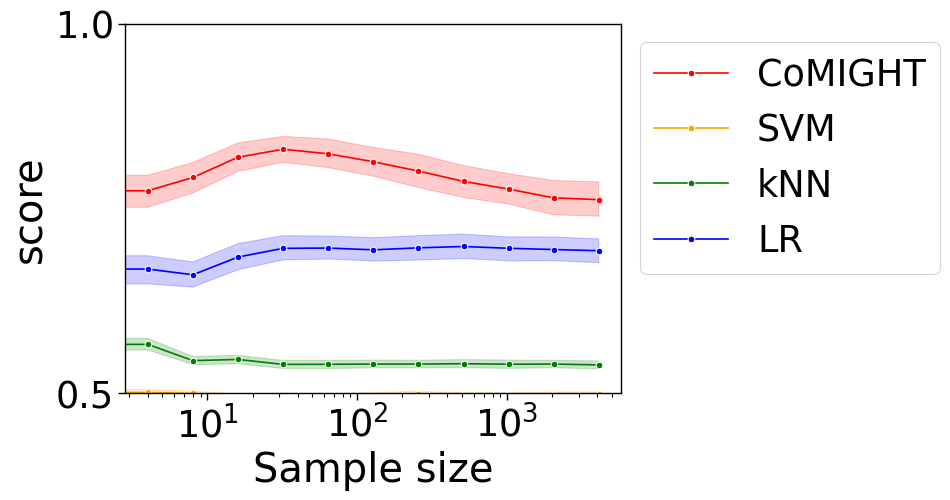

In [110]:
sns.set_context("paper", font_scale=3.0)
fig, ax = plt.subplots()

palette = {"CoMIGHT": "red", "SVM": "orange", "kNN": "green", "LR": "blue"}

ax = sns.lineplot(
    data=df,
    x="n_features_2",
    y="score",
    marker="o",
    hue="model",
    ax=ax,
    palette=palette,
    errorbar="ci",
)

# ax.set_ylabel("Partial-AUC \n(at 90% Specificity)")
# ax.set_xlabel("Number of variables in X2")
ax.set_xlabel("Sample size")
# ax.set_title("Collider\n")
# ax.axvline([32], ls="--", color="black", label="Noise Dimensions")
ax.set(
    ylim=[0.5, 1],
    yticks=[0.5, 1],
    # xticks=[0, 50, 100, 1000, 4000],
)
ax.set_xscale("log")
# xticks = ax.get_xticks()
# print(xticks)
# xticks = np.concatenate(([0], xticks))
# ax.set(xticks=xticks)
ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [71]:
df = pd.DataFrame(np.concatenate((X, y[:, np.newaxis]), axis=1))
x_cols = np.array([f"x{idx}" for idx in range(X.shape[1])])
y_cols = np.array([f"y0"])
z_cols = x_cols[0:2]
df.columns = np.hstack((x_cols, y_cols))
print(df.columns)

NameError: name 'X' is not defined